### Christopher Ortiz
10/21/2020<br>
Contact me: [Gmail](christopher.logan.ortiz@gmail.com)<br>
View my portfolio on [Github](https://github.com/Promeos)

## Purpose of the project
> Use the 2017 properties and predictions data for [single unit/single family homes](#Definitions)... <strong>include the discoveries you made</strong> and work you have done <strong>related to uncovering the drivers Zillow's Zestimate error</strong>.

<img src="https://prnewswire2-a.akamaihd.net/p/1893751/sp/189375100/thumbnail/entry_id/1_su9da4fu/def_height/1001/def_width/1911/version/100011/type/2/q/100"  width="300" height="200">

---

## Who is Zillow®?

>Zillow® offers buying, selling, renting, and financing services for residential real estate.[*](#Appendix)
>    - Zillow <strong>buys and sells</strong> properties
>
><strong>Short answer: They're in the real estate game!</strong>


## What's a Zestimate®?

> The Zestimate® home valuation model is Zillow’s estimate of a home's market value.[*](#Appendix)<br>
>
> <strong>The Zestimate incorporates</strong>:
> 1. <code style="background:lemonchiffon;color:black">Public data</code>
> 1. <code style="background:lemonchiffon;color:black">User-submitted data</code>
> 1. <code style="background:lemonchiffon;color:black">Taking into account home facts</code>
> 1. Location
> 1. Market conditions

## What's a logerror?

><strong>Zestimate error</strong>
>
> The Zestimate's accuracy is computed by comparing the final sale price to the Zestimate that was published on or just prior to the sale date.
>
> $\large logerror = log(Zestimate) - log(SalesPrice)$[*](#Appendix)


## Why is reducing logerror important to Zillow?

> Zillow's business model is to provide reliable real estate assets and services!
>
> Zillow buys/sells assets that have a long shelf life. Purchasing a home is considered a major (life) purchase.
>
> <strong>Knowing what the market is like and what your inventory is worth at any given time is a strategic advantage - it reduces uncertainty/risk.</strong>

---

# Driver's of logerror
> Part 1. Inside the data<br>
> Part 2. Outside the data

<br>

# Part 1: Inside the data
## Acquisition and Preparation



```sql
    select *
    from properties_2017
    join(select parcelid,
        logerror,
        max(transactiondate) as lasttransactiondate
        from predictions_2017
        group by parcelid, logerror
        ) as predictions using(parcelid)
    left join `airconditioningtype` using(`airconditioningtypeid`)
    left join `architecturalstyletype` using(`architecturalstyletypeid`)
    left join `buildingclasstype` using(`buildingclasstypeid`)
    left join `heatingorsystemtype` using(`heatingorsystemtypeid`)
    left join `propertylandusetype` using(`propertylandusetypeid`)
    left join `storytype` using(`storytypeid`)
    left join `typeconstructiontype` using(`typeconstructiontypeid`)
    where (latitude is not null
    and longitude is not null
    and propertylandusetypeid = 261)
```

<br>
<br>
Drop columns with 100% missing values

Create new features<br>
* has_basement
* has_hottub_or_spa
* has_pool
* pool_area
* has_patio
* patio_area_sqft
* has_shed
* shed_area_sqft
* num_of_bathrooms
* num_of_bedrooms
* lot_size_sqft

| Home Features | Description |
| :------ | :---------- |
| `parcelid` | Unique identifier for parcels (lots) |
| `basement_area_sqft` | Finished living area below or partially below ground level |
| `num_of_bedrooms` | Number of bedrooms in home |
| `num_of_restrooms` | Number of bathrooms in home including fractional bathrooms  |
| `living_room_sqft` | Living room square feet | 
| `lot_size_sqft` | Area of the lot in square feet |
| `year_built` | The Year the principal residence was built |
| `has_basement` | If the home has a basement |
| `basement_area_sqft` | The area of the basement |
| `has_hottub_orspa` | Does the home have a hot tub or spa |
| `has_pool` | If the home has a pool |
| `pool_area_sqft` | Area of pool in square feet |
| `has_patio` | If the home has a patio in yard |
| `patio_sqft` | Pool without hot tub |
| `has_shed` | If the home has a storage shed/building in yard |


| Tax Features | Description |
| :------ | :---------- |
| `property_tax` |The total property tax assessed for that assessment year |
| `taxable_value` | The total tax assessed value of the parcel |
| `structure_tax` | The assessed value of the built structure on the parcel |
| `land_tax` |The assessed value of the land area of the parcel |


| Location Features | Description |
| :------ | :---------- |
| `latitude` | Latitude of the middle of the parcel divided by 10e6 |
| `longitude` | Longitude of the middle of the parcel divided by 10e6 |
| `fips` | Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details |

# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from prepare import prepare_zillow
from wrangle import train_validate_test, impute_values, attributes_target_split, add_scaled_columns

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = prepare_zillow()
train, validate, test = train_validate_test(df)
train, validate, test = impute_values(train, validate, test)

geo_features = ['fips', 'latitude', 'longitude', 'logerror']


home_features = ['num_of_bedrooms',
                 'num_of_restrooms',
                 'living_room_area_sqft',
                 'lot_size_sqft',
                 'year_built',
                 'has_basement',
                 'has_hottub_or_spa',
                 'has_pool',
                 'pool_area_sqft',
                 'has_patio',
                 'patio_area_sqft',
                 'has_shed',
                 'basement_area_sqft',
                 'logerror']

tax_features = ['property_tax',
                'structure_tax',
                'land_tax',
                'taxable_value',
                'logerror']

distributions = train.copy()

# drop the date column for now
distributions.drop(columns='date_sold', inplace=True)

geo_dists = distributions[geo_features].copy()
home_dists = distributions[home_features].copy()
tax_dists = distributions[tax_features].copy()

## Distributions of each feature and logerror

Distributions of Location Features<br>

- Properties in Los Angeles County are the most represented.
- Largest logerrors occur in Los Angeles.

Distributions of Home Features
- The largest logerrors occur between 2 and 5 bedrooms

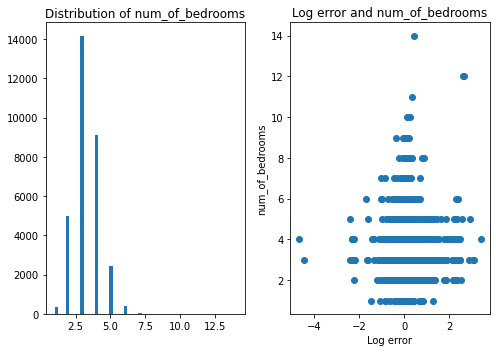

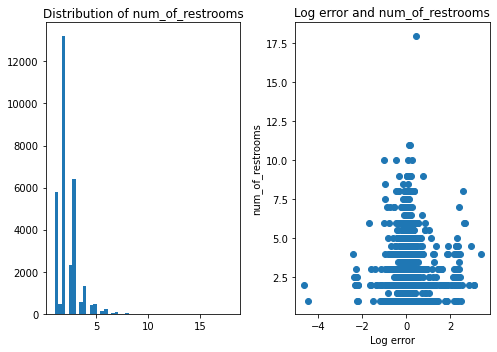

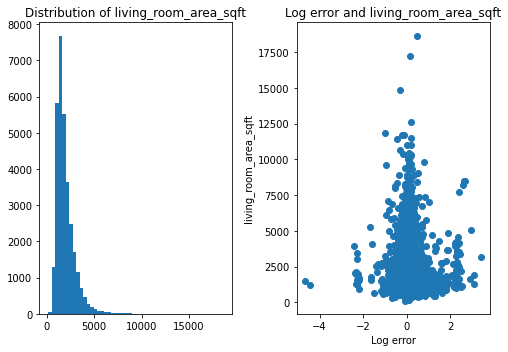

In [4]:
for i in home_dists.columns[:3]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,5))
    fig.subplots_adjust(left=None, bottom=0.1, right=0.9, top=0.9, wspace=0.9, hspace=0.2)
    ax1.hist(home_dists[i], bins=50)
    ax2.scatter(home_dists.logerror, home_dists[i])
    ax1.title.set_text(f'Distribution of {i}')
    ax2.title.set_text(f'Log error and {i}')
    ax2.set_xlabel('Log error')
    ax2.set_ylabel(f'{i}')
    plt.tight_layout()
    plt.show()

Distributions of Tax Features<br>
- Charts are too noisy.

## Correlations of each feature and logerror
Features that describe the inside of the property are correlated with logerror

1. living_room_area_sqft
1. num_of_bedrooms
1. num_of_restrooms

## Cluster Features

Cluster 1: A place with a view<br>
`longitude_scaled`<br>
`latitude_scaled`<br>
`structure_tax_scaled`

Cluster 2: Extras<br>
`has_basement_scaled`<br>
`has_hottub_or_spa_scaled`<br>
`has_pool_scaled`<br>
`has_patio_scaled`<br>
`has_shed_scaled`

Cluster 3: Inside, outside, and how old<br>
`living_room_area_sqft_scaled`<br>
`lot_size_sqft_scaled`<br>
`year_built_scaled`<br>

## Hypothesis Tests

1. logerrors are significantly different than the mean logerror of the population in Los Angeles County and Ventura County.

2. Properties with more than 5 bedroom and 5 bathrooms have a significantly different mean logerror than properties with less than 5 bedrooms or bathrooms.

3. logerrors are dependent on restrooms and bathrooms.

4. logerrors are dependent on all three clusters.

5. logerrors were not significantly different for homes with reported features and those without (when tested individually).
> has_pool and has_patio were almost statistically significant<br>
> not enough reported extras

# Modeling

Linear Regression

Hyperparameter: C = .2

Features used:<br>
`num_of_bedrooms_scaled`<br>
`num_of_restrooms_scaled`<br>
`living_room_area_sqft_scaled`<br>
`longitude_scaled`<br>
`cluster_3_4` == Inside, outside, and how old<br>

[Selected using SelectKBest]

| Model | RMSE |
|:---|:---|
| Baseline Mean Logerror | 0.179381 |
| Baseline Median Logerror | 0.179683 |
| Train Logerror | 0.179059 |
| Validate Logerror | 0.180943 |
| Test Logerror | 0.181490 |

|Delta|% change|
|:---|:---|
| Delta Mean | 1.1762% |
| Delta Median | 1.0057% |

# Next Steps

Tackling Zestimate error from outside the data.

## Free option: Google Maps

<img src="street_view.png" width="1000" height="1000">


<img src="aerial_view.png" width="500" height="400">

## Not free options
- Real Estate Agents
    - Agents in the field report any discrete data points (num_of_restrooms)
    - Incentivize reporting: A cool, limited edition, Zillow sticker
- General Contractors & Property Owners
    - Report home improvements to Zillow
    - Incentivize reporting: A cool Zillow sticker
- Property Owners
    - Send a flyer in the mail.
    - Incentivize reporting: A cool Zillow sticker

---
# Appendix

*Zillow also provides marketing software, technology solutions, and advertising services.<br>
Source: [Yahoo Finance](https://finance.yahoo.com/quote/Z/profile?p=Z)

*Zestimate®<br>
Source: [Zillow](#https://www.zillow.com/zestimate/)
---

# Definitions

Single Family Home

>This definition comes from the [US Census](https://www.census.gov/construction/chars/definitions/) website.
>    
><strong>Attached and Detached Single-Family Housing Units</strong>
>
> Single-family structures include fully detached, semi-detached (semi-attached, side-by-side), row houses, duplexes, quadruplexes, and townhouses. In order for attached units to be classified as single-family structures, each unit must:
>
> - Be separated by a ground-to roof wall,
> - Have a separate heating system,
> - Have individual meters for public utilities, and
> - Have no units located above or below.
>
> If each unit within the building does not meet the conditions above, the building is considered multifamily.

<br>

>Another definition from The City of Los Angeles Municipal [codes](https://codelibrary.amlegal.com/codes/los_angeles/latest/lapz/0-0-0-886).
>     
><strong>DWELLING UNIT</strong>
>    
> A group of two or more rooms, one of which is a kitchen, designed for occupancy by one family for living and sleeping purposes.  (Amended by Ord. No. 107,884, Eff. 9/23/56.)    
>    
><strong>FAMILY</strong>
>
> One or more persons living together in a dwelling unit, with common access to, and common use of all living, kitchen, and eating areas within the dwelling unit.  (Amended by Ord. No. 177,325, Eff. 3/18/06.)

<br>    
    